In [1]:
!pip install pymorphy2 torchinfo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 78.1 MB/s eta 0:00:00


# Importing libraries - Импорт библиотек

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingWarmRestarts
from torchinfo import summary

from tqdm import tqdm_notebook
import tqdm
import pandas as pd
import numpy as np
import pymorphy2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import nltk
import string

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

device = 'cuda' if torch.cuda.is_available() else 'cpu'

2024-07-23 08:12:45.218160: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-23 08:12:45.218261: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-23 08:12:45.343237: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
warnings.simplefilter('ignore')
warnings.filterwarnings("ignore")

In [4]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
def evaluate_binary_classification(y_true, y_pred, pos_label='Positive'):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, pos_label=pos_label, average='binary')
    recall = recall_score(y_true, y_pred, pos_label=pos_label, average='binary')
    f1 = f1_score(y_true, y_pred, pos_label=pos_label, average='binary')

    metrics = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }

    return metrics

In [6]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

class Metrics:
    @staticmethod
    def f1_score_binary(y_true, y_pred):
        return f1_score(y_true, y_pred)

    @staticmethod
    def precision_binary(y_true, y_pred):
        return precision_score(y_true, y_pred)

    @staticmethod
    def recall_binary(y_true, y_pred):
        return recall_score(y_true, y_pred)

    @staticmethod
    def accuracy_binary(y_true, y_pred):
        return accuracy_score(y_true, y_pred)
    
    @staticmethod
    def f1_score_multiclass(y_true, y_pred):
        return f1_score(y_true, y_pred, average='weighted')

    @staticmethod
    def precision_multiclass(y_true, y_pred):
        return precision_score(y_true, y_pred, average='weighted')

    @staticmethod
    def recall_multiclass(y_true, y_pred):
        return recall_score(y_true, y_pred, average='weighted')

    @staticmethod
    def accuracy_multiclass(y_true, y_pred):
        return accuracy_score(y_true, y_pred)

# Data analysis - Анализ данных

In [7]:
data = pd.read_csv('/kaggle/input/determining-the-sentiment-of-bank-reviews-dataset/train.csv', sep='\t')
data['tag'] = 'train'
encode_class = {i: lab for i, lab in enumerate(data['Score'].unique())}
decode_class = {encode_class[i]: i for i in encode_class}
data['Score_num'] = data['Score'].apply(lambda x: decode_class[x])
data

,idx,Score,Text,tag,Score_num
0,0,Positive,В Альфа-Банке работает замечательная девушка -...,train,0
1,1,Negative,Оформляя рассрочку в м. Видео в меге тёплый ст...,train,1
2,2,Positive,Очень порадовала оперативность работы в банке....,train,0
3,3,Negative,Имела неосторожность оформить потреб. кредит в...,train,1
4,4,Negative,Небольшая предыстория: Нашел на сайте MDM банк...,train,1
...,...,...,...,...,...
13994,13994,Positive,"О высокой надёжности МКБ, порядочности и добро...",train,0
13995,13995,Positive,"Обслуживаюсь в офисе на Чернореченской 42а, ка...",train,0
13996,13996,Positive,Попала сегодня в очень неприятную ситуацию. Ре...,train,0
13997,13997,Positive,Добрый день! Давно являюсь клиентом банка Русс...,train,0


In [8]:
test = pd.read_csv('/kaggle/input/determining-the-sentiment-of-bank-reviews-dataset/test.csv', sep='\t')
test['tag'] = 'test'
test

,idx,Text,tag
0,13999,Замечательная история об открытии счета в банк...,test
1,14000,"23.07.14г. я досрочно внес сумму, указанную оп...",test
2,14001,Была задолженность по кредитной карте. Банк по...,test
3,14002,Срочно понадобилась определенная денежная сумм...,test
4,14003,Здравствуйте. В местном отделении Бинбанка г. ...,test
...,...,...,...
5995,19994,Уважаемые представители Русфинанс Банка! Прошу...,test
5996,19995,04 июня сняли с дебетовой карты банка 10 000 T...,test
5997,19996,В апреле решил я купить шуруповерт. Посмотрел ...,test
5998,19997,Недавно взял потребкредит в этом банке. Все че...,test


In [9]:
data_text = pd.concat([data.drop(columns=['Score', 'Score_num']), test])
data_text

,idx,Text,tag
0,0,В Альфа-Банке работает замечательная девушка -...,train
1,1,Оформляя рассрочку в м. Видео в меге тёплый ст...,train
2,2,Очень порадовала оперативность работы в банке....,train
3,3,Имела неосторожность оформить потреб. кредит в...,train
4,4,Небольшая предыстория: Нашел на сайте MDM банк...,train
...,...,...,...
5995,19994,Уважаемые представители Русфинанс Банка! Прошу...,test
5996,19995,04 июня сняли с дебетовой карты банка 10 000 T...,test
5997,19996,В апреле решил я купить шуруповерт. Посмотрел ...,test
5998,19997,Недавно взял потребкредит в этом банке. Все че...,test


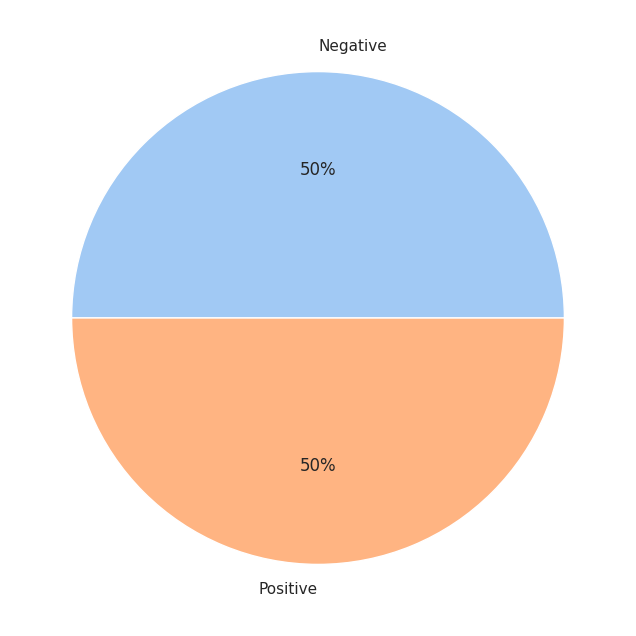

In [10]:
sns.set(rc={'figure.figsize': (15, 8)})
colors = sns.color_palette('pastel')[0:5]
labels = sorted(data['Score'].unique())
dt = np.array([len(data[data['Score'] == i])for i in labels])
plt.pie(dt, labels=labels, colors = colors, autopct='%.0f%%')
plt.show()

In [11]:
morph = pymorphy2.MorphAnalyzer()

In [12]:
for elem in string.punctuation:
    data_text['Text'] = data_text['Text'].apply(lambda x: x.replace(elem, ''))
data_text['Text'] = data_text['Text'].apply(lambda x: ' '.join(x.split()).lower())
data_text['Text'] = data_text['Text'].apply(lambda x: re.sub("[^a-zA-Zа-яА-ЯёЁ]", " ", x).lower())

s_w = stopwords.words('russian')
data_text['Text_clear_stop_words'] = data_text['Text'].apply(
    lambda x: ' '.join([i for i in nltk.word_tokenize(x, language="russian") if i not in s_w])
)

Text_lemmatize = []
for x in tqdm_notebook(data_text['Text_clear_stop_words']):
    Text_lemmatize.append(' '.join(
    morph.parse(word)[0].normal_form for word in x.split()
).lower())
data_text['Text_lemmatize'] = Text_lemmatize
Text_lemmatize.clear()

  0%|          | 0/19999 [00:00<?, ?it/s]

In [13]:
data_text

,idx,Text,tag,Text_clear_stop_words,Text_lemmatize
0,0,в альфабанке работает замечательная девушка ил...,train,альфабанке работает замечательная девушка илья...,альфабанка работать замечательный девушка илья...
1,1,оформляя рассрочку в м видео в меге тёплый ста...,train,оформляя рассрочку м видео меге тёплый стан по...,оформлять рассрочка м видео мег тёплый стан по...
2,2,очень порадовала оперативность работы в банке ...,train,очень порадовала оперативность работы банке за...,очень порадовать оперативность работа банк зак...
3,3,имела неосторожность оформить потреб кредит в ...,train,имела неосторожность оформить потреб кредит ал...,иметь неосторожность оформить потреба кредит а...
4,4,небольшая предыстория нашел на сайте mdm банка...,train,небольшая предыстория нашел сайте mdm банка ин...,небольшой предыстория найти сайт mdm банк инте...
...,...,...,...,...,...
5995,19994,уважаемые представители русфинанс банка прошу ...,test,уважаемые представители русфинанс банка прошу ...,уважаемый представитель русфинанс банк просить...
5996,19995,июня сняли с дебетовой карты банка t...,test,июня сняли дебетовой карты банка twd тысяч руб...,июнь снять дебетовый карта банк twd тысяча руб...
5997,19996,в апреле решил я купить шуруповерт посмотрел ц...,test,апреле решил купить шуруповерт посмотрел цены ...,апрель решить купить шуруповерт посмотреть цен...
5998,19997,недавно взял потребкредит в этом банке все чес...,test,недавно взял потребкредит банке честно месяца ...,недавно взять потребкредить банк честно месяц ...


## TfidfVectorizer

In [14]:
vectorizer_Tfidf = TfidfVectorizer()
vectorizer_Tfidf.fit(data_text['Text_lemmatize'])

TfidfVectorizer()

## CountVectorizer

In [15]:
vectorizer_CountVect = CountVectorizer()
vectorizer_CountVect.fit(data_text['Text_lemmatize'])

CountVectorizer()

## Tokenizer text

In [16]:
texts = data_text['Text_lemmatize'].to_list()
print('max len symbols', max(map(lambda x: len(x), texts)))
print('max len text', max(map(lambda x: len(x.split()), texts)))
text_set = []
for i in texts:
    text_set.extend(i.split())
print('max count words', len(set(text_set)))

max len symbols 17689
max len text 2294
max count words 94262


In [17]:
maxWordsCount = 94262
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!–"—#$%&()*+,-./:;<=>?@[\]^_`{|}~\t\n\r«»', lower=True, split=' ', char_level=False)
tokenizer.fit_on_texts(texts)

In [18]:
texts[0]

'альфабанка работать замечательный девушка ильясова орный вежливый отзывчивый действительно участвовать запрос клиент приходить подряд ровно день каждый день помнить время мой приход помочь оформить кредит размер млн рубль прийти партнёр передавать получить кредит покупать я авто специалист ильясова орный помочь мы вывести сумма день это непросто сделка состояться остаться довольный знакомый конец добавить понять почему прислать это отделение девушкебольшой такой замечательный специалист приобретать программа здоровье вообще связать альфабанк быть'

In [19]:
pad_sequences(tokenizer.texts_to_sequences([texts[0]]), maxlen=2294)

array([[   0,    0,    0, ..., 1372,  187,   57]], dtype=int32)

In [20]:
print(len(list(tokenizer.word_index.items())))
print(list(tokenizer.word_index.items())[-100:])

94262
[('страхованиипомнить', 94163), ('болеен', 94164), ('заключатьпойти', 94165), ('кантор', 94166), ('повериться', 94167), ('вопросовольга', 94168), ('свердловскоебыть', 94169), ('информациюпросто', 94170), ('краденый', 94171), ('альфабанкеситуация', 94172), ('дзержинскогон', 94173), ('знаемдругий', 94174), ('беспошлинно', 94175), ('желанияести', 94176), ('кредиткак', 94177), ('подуев', 94178), ('процентыиз', 94179), ('клиентовиза', 94180), ('страховкупереть', 94181), ('использованияутеря', 94182), ('былопривести', 94183), ('банкоматовдалый', 94184), ('ситуациятаким', 94185), ('григ', 94186), ('действуетпытаться', 94187), ('хорошочтый', 94188), ('воспользоватьсяпросьба', 94189), ('окноподходить', 94190), ('картыпослать', 94191), ('обрадоваласьсотрудница', 94192), ('былопросто', 94193), ('рухнулиа', 94194), ('технтрудность', 94195), ('ладноладный', 94196), ('какаятой', 94197), ('невинно', 94198), ('офиситог', 94199), ('решенполучить', 94200), ('роботаассистент', 94201), ('упаковочный

# train_test_split

In [21]:
X = data_text[data_text['tag'] == 'train']['Text_lemmatize'].to_list()
Y = data['Score_num'].to_numpy()

In [22]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=True)

In [23]:
len(X_train), len(Y_train), len(X_valid), len(Y_valid)

(11199, 11199, 2800, 2800)

In [24]:
class TextData(Dataset):
    def __init__(self, vectorizer_Tfidf, vectorizer_CountVect, tokenizer, max_token, data, labels=None):
        self.text_data = data
        self.vectorizer_Tfidf = vectorizer_Tfidf
        self.vectorizer_CountVect = vectorizer_CountVect
        self.tokenizer = tokenizer
        self.max_token = max_token
        
        if labels is not None:
            self.labels = list(labels)
        else:
            self.labels = []

    def __len__(self):
        return len(self.text_data)

    def __getitem__(self, idx):
        sample = {}
        sample['Tfidf'] = torch.tensor(self.vectorizer_Tfidf.transform([self.text_data[idx]]).toarray()[0])
        sample['CountVect'] = torch.tensor(self.vectorizer_CountVect.transform([self.text_data[idx]]).toarray()[0])
        sample['tokenizer'] = torch.tensor(pad_sequences(
            self.tokenizer.texts_to_sequences([self.text_data[idx]]), maxlen=2294
        )[0]) / self.max_token
        if self.labels:
            sample['labels'] = torch.tensor(self.labels[idx])
        else:
            sample['labels'] = 0
        return sample

In [25]:
train_dataset = TextData(vectorizer_Tfidf, vectorizer_CountVect, tokenizer, 94262, data=X_train, labels=Y_train)
valid_dataset = TextData(vectorizer_Tfidf, vectorizer_CountVect, tokenizer, 94262, data=X_valid, labels=Y_valid)

batch_size = 16
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, num_workers=8, pin_memory=True)
valid_loader = DataLoader(valid_dataset, shuffle=False, batch_size=batch_size, num_workers=8, pin_memory=True)

In [26]:
for x in train_loader:
    break

In [27]:
x

{'Tfidf': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64),
 'CountVect': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]),
 'tokenizer': tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 9.6646e-03, 1.5383e-03,
          5.9409e-04],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.6337e-03, 6.7153e-03,
          1.0609e-05],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 3.7588e-01, 5.2089e-03,
          1.2158e-02],
         ...,
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.2837e-03, 1.2730e-04,
          8.2748e-04],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 

In [28]:
x['Tfidf'].size()

torch.Size([16, 94214])

In [29]:
x['CountVect'].size()

torch.Size([16, 94214])

In [30]:
x['tokenizer'].size()

torch.Size([16, 2294])

In [31]:
x['tokenizer'].dtype

torch.float32

# Architecture

In [32]:
class SimpleNet_NLP(nn.Module):
    def __init__(self, hidden_dim, max_len_text, hidden_input_Tfidf, hidden_input_CountVect):
        super(SimpleNet_NLP, self).__init__()
        self.fc_tokenizer = nn.Sequential(
            nn.Linear(max_len_text, hidden_dim),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.Dropout(0.3)
        )
        
        self.fc_tfidf = nn.Sequential(
            nn.Linear(hidden_input_Tfidf, hidden_dim),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.Dropout(0.3)
        )
        
        self.fc_countvect = nn.Sequential(
            nn.Linear(hidden_input_CountVect, hidden_dim),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.Dropout(0.3)
        )
        
        self.fc_classifier = nn.Sequential(
            nn.Linear(hidden_dim * 3 // 2, hidden_dim),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim // 2, 2)
        )
        
        self.init_weights()
    
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
    
    def forward(self, x_tokenizer, x_tfidf, x_countvect):
        x_tokenizer = self.fc_tokenizer(x_tokenizer)
        x_tfidf = self.fc_tfidf(x_tfidf.float())
        x_countvect = self.fc_countvect(x_countvect.float())
        
        x = torch.cat((x_tokenizer, x_tfidf, x_countvect), dim=-1)
        output = self.fc_classifier(x)
        return output

In [33]:
HIDDEN_DIM = 1024
max_len_text = 2294

In [34]:
model = SimpleNet_NLP(
    hidden_dim=HIDDEN_DIM,
    max_len_text=max_len_text,
    hidden_input_Tfidf=94214,
    hidden_input_CountVect=94214
).to(device)
model

SimpleNet_NLP(
  (fc_tokenizer): Sequential(
    (0): Linear(in_features=2294, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.3, inplace=False)
  )
  (fc_tfidf): Sequential(
    (0): Linear(in_features=94214, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.3, inplace=False)
  )
  (fc_countvect): Sequential(
    (0

In [35]:
for x in train_loader:
    break

In [36]:
# model(x['tokenizer'].to(device), x['Tfidf'].to(device), x['CountVect'].to(device))

In [37]:
summary(model, input_data=(x['tokenizer'].to(device), x['Tfidf'].to(device), x['CountVect'].to(device)))

Layer (type:depth-idx)                   Output Shape              Param #
SimpleNet_NLP                            [16, 2]                   --
├─Sequential: 1-1                        [16, 512]                 --
│    └─Linear: 2-1                       [16, 1024]                2,350,080
│    └─ReLU: 2-2                         [16, 1024]                --
│    └─BatchNorm1d: 2-3                  [16, 1024]                2,048
│    └─Dropout: 2-4                      [16, 1024]                --
│    └─Linear: 2-5                       [16, 512]                 524,800
│    └─ReLU: 2-6                         [16, 512]                 --
│    └─BatchNorm1d: 2-7                  [16, 512]                 1,024
│    └─Dropout: 2-8                      [16, 512]                 --
├─Sequential: 1-2                        [16, 512]                 --
│    └─Linear: 2-9                       [16, 1024]                96,476,160
│    └─ReLU: 2-10                        [16, 1024]        

In [38]:
class Trainer_model:
    def __init__(self, model, device):
        self.model = model
        self.device = device

        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=1e-3, weight_decay=1e-2)
        self.scheduler = CosineAnnealingWarmRestarts(self.optimizer, T_0=10, T_mult=2)
        self.loss_function = nn.CrossEntropyLoss()
        self.metrics_functions = Metrics

    def train_one_epoch(self, data_loader, num_ep):
        self.model.train(True)
        total_loss = 0.0
        total_samples = 0
        metric_res = {
            'f1_score': 0.0,
            'precision': 0.0,
            'recall': 0.0,
            'accuracy': 0.0
        }
        print(f'Epoch train: {num_ep + 1}')
        print('-----------------------------------')
        for batch_index, batch in enumerate(tqdm_notebook(data_loader)):
            x_tokenizer, x_Tfidf = batch['tokenizer'].to(self.device), batch['Tfidf'].to(self.device)
            x_CountVect, y_batch = batch['CountVect'].to(self.device), batch['labels'].to(self.device)

            self.optimizer.zero_grad()
            output = self.model(x_tokenizer, x_Tfidf, x_CountVect)
            loss = self.loss_function(output.squeeze(), y_batch)

            batch_size = x_tokenizer.size(0)
            total_loss += loss.item() * batch_size
            total_samples += batch_size

            output_argmax = torch.argmax(output, axis=1)
            metric_res['f1_score'] += self.metrics_functions.f1_score_binary(y_batch.cpu(), output_argmax.cpu()) * batch_size
            metric_res['precision'] += self.metrics_functions.precision_binary(y_batch.cpu(), output_argmax.cpu()) * batch_size
            metric_res['recall'] += self.metrics_functions.recall_binary(y_batch.cpu(), output_argmax.cpu()) * batch_size
            metric_res['accuracy'] += self.metrics_functions.accuracy_binary(y_batch.cpu(), output_argmax.cpu()) * batch_size

            loss.backward()
            self.optimizer.step()

        avg_loss = total_loss / total_samples
        print(f'loss train: {avg_loss}')
        metric_res = {i: metric_res[i] / total_samples for i in metric_res}
        for metric in metric_res:
            print(f'{metric}: {metric_res[metric]}')
        return avg_loss, metric_res

    def validation_one_epoch(self, data_loader):
        self.model.eval()
        total_loss = 0.0
        total_samples = 0
        metric_res = {
            'f1_score': 0.0,
            'precision': 0.0,
            'recall': 0.0,
            'accuracy': 0.0
        }
        for batch_index, batch in enumerate(tqdm_notebook(data_loader)):
            x_tokenizer, x_Tfidf = batch['tokenizer'].to(self.device), batch['Tfidf'].to(self.device)
            x_CountVect, y_batch = batch['CountVect'].to(self.device), batch['labels'].to(self.device)
            
            with torch.no_grad():
                output = self.model(x_tokenizer, x_Tfidf, x_CountVect)
                loss = self.loss_function(output.squeeze(), y_batch)

            batch_size = x_tokenizer.size(0)
            total_loss += loss.item() * batch_size
            total_samples += batch_size

            output_argmax = torch.argmax(output, axis=1)
            metric_res['f1_score'] += self.metrics_functions.f1_score_binary(y_batch.cpu(), output_argmax.cpu()) * batch_size
            metric_res['precision'] += self.metrics_functions.precision_binary(y_batch.cpu(), output_argmax.cpu()) * batch_size
            metric_res['recall'] += self.metrics_functions.recall_binary(y_batch.cpu(), output_argmax.cpu()) * batch_size
            metric_res['accuracy'] += self.metrics_functions.accuracy_binary(y_batch.cpu(), output_argmax.cpu()) * batch_size

        avg_loss = total_loss / total_samples
        print(f'Loss validation: {avg_loss}')
        metric_res = {i: metric_res[i] / total_samples for i in metric_res}
        for metric in metric_res:
            print(f'{metric}: {metric_res[metric]}')
        print('-----------------------------------')
        print()
        return avg_loss, metric_res

In [39]:
trainer = Trainer_model(model, device)

In [40]:
epoches = 32

train_losses = []
metric_res_train = {
        'f1_score': [],
        'precision': [],
        'recall': [],
        'accuracy': []
    }

valid_losses = []
metric_res_valid = {
        'f1_score': [],
        'precision': [],
        'recall': [],
        'accuracy': []
    }


best_metrics = {
    'f1_score': 0,
    'precision': 0,
    'recall': 0,
    'accuracy': 0
}
best_model_wts = 'model'
min_loss = 10**9

for epoch in range(epoches):
    losses_train_epoch, metric_res_train_epoch = trainer.train_one_epoch(train_loader, epoch)
    train_losses.append(losses_train_epoch)
    for i in metric_res_train_epoch:
        metric_res_train[i].append(metric_res_train_epoch[i])

    losses_val_epoch, metric_res_val_epoch = trainer.validation_one_epoch(valid_loader)
    valid_losses.append(losses_val_epoch)
    for i in metric_res_val_epoch:
        metric_res_valid[i].append(metric_res_val_epoch[i])

    if any([best_metrics[i] < metric_res_val_epoch[i] for i in metric_res_val_epoch]) and min_loss > losses_val_epoch:
        best_model_wts = trainer.model.state_dict()
        best_metrics = {i: metric_res_val_epoch[i] for i in metric_res_val_epoch}
        min_loss = losses_val_epoch

    trainer.scheduler.step(losses_val_epoch)

Epoch train: 1
-----------------------------------


  0%|          | 0/700 [00:00<?, ?it/s]

loss train: 0.36537109589794137
f1_score: 0.8641350991424197
precision: 0.85967691662843
recall: 0.8949975008373084
accuracy: 0.8674881685864809


  0%|          | 0/175 [00:00<?, ?it/s]

Loss validation: 0.19024921367211
f1_score: 0.9237932138458608
precision: 0.9160165865880153
recall: 0.9395471036899609
accuracy: 0.9271428571428572
-----------------------------------

Epoch train: 2
-----------------------------------


  0%|          | 0/700 [00:00<?, ?it/s]

loss train: 0.14495820098017112
f1_score: 0.9397252950879881
precision: 0.9376738827046891
recall: 0.9544545422927428
accuracy: 0.9424055719260648


  0%|          | 0/175 [00:00<?, ?it/s]

Loss validation: 0.19223104312483755
f1_score: 0.9247396332200557
precision: 0.914571571285857
recall: 0.9434205318491033
accuracy: 0.9275
-----------------------------------

Epoch train: 3
-----------------------------------


  0%|          | 0/700 [00:00<?, ?it/s]

loss train: 0.0809335830075551
f1_score: 0.9666741726884733
precision: 0.9645233733634483
recall: 0.9766324655689778
accuracy: 0.9691043843200285


  0%|          | 0/175 [00:00<?, ?it/s]

Loss validation: 0.19958272146327155
f1_score: 0.9255570481152618
precision: 0.9223907838193551
recall: 0.9369894232751379
accuracy: 0.9278571428571428
-----------------------------------

Epoch train: 4
-----------------------------------


  0%|          | 0/700 [00:00<?, ?it/s]

loss train: 0.07019303495354444
f1_score: 0.9717794182542281
precision: 0.9699394413565327
recall: 0.9809004877314548
accuracy: 0.9744620055362085


  0%|          | 0/175 [00:00<?, ?it/s]

Loss validation: 0.21383892049480763
f1_score: 0.9123433292097672
precision: 0.9379039373325088
recall: 0.8979657168228597
accuracy: 0.9182142857142858
-----------------------------------

Epoch train: 5
-----------------------------------


  0%|          | 0/700 [00:00<?, ?it/s]

loss train: 0.05779171263110413
f1_score: 0.9766040552269566
precision: 0.9745481294905349
recall: 0.9852678242177301
accuracy: 0.9798196267523887


  0%|          | 0/175 [00:00<?, ?it/s]

Loss validation: 0.2050024114442723
f1_score: 0.9233334149815846
precision: 0.9290328560328559
recall: 0.928547103689961
accuracy: 0.9282142857142858
-----------------------------------

Epoch train: 6
-----------------------------------


  0%|          | 0/700 [00:00<?, ?it/s]

loss train: 0.056069971087794275
f1_score: 0.9782301718027689
precision: 0.9747519974147356
recall: 0.9874699696826669
accuracy: 0.9810697383694973


  0%|          | 0/175 [00:00<?, ?it/s]

Loss validation: 0.22027024678885937
f1_score: 0.9296376912372221
precision: 0.9215060177917318
recall: 0.9446676973819833
accuracy: 0.9310714285714285
-----------------------------------

Epoch train: 7
-----------------------------------


  0%|          | 0/700 [00:00<?, ?it/s]

loss train: 0.05378186045816954
f1_score: 0.9810056896851005
precision: 0.9795897309425299
recall: 0.9861730633763854
accuracy: 0.9841057237253327


  0%|          | 0/175 [00:00<?, ?it/s]

Loss validation: 0.2568382137215563
f1_score: 0.9230787092746096
precision: 0.9057250210107348
recall: 0.9484821686250259
accuracy: 0.9242857142857143
-----------------------------------

Epoch train: 8
-----------------------------------


  0%|          | 0/700 [00:00<?, ?it/s]

loss train: 0.04145393097888248
f1_score: 0.9846635901838714
precision: 0.9842519952886953
recall: 0.9884509850756837
accuracy: 0.986070184837932


  0%|          | 0/175 [00:00<?, ?it/s]

Loss validation: 0.2340179589071444
f1_score: 0.9240484392926828
precision: 0.8926763395334819
recall: 0.9659150690579261
accuracy: 0.9228571428571428
-----------------------------------

Epoch train: 9
-----------------------------------


  0%|          | 0/700 [00:00<?, ?it/s]

loss train: 0.03645362844358555
f1_score: 0.9852061932485547
precision: 0.9832025818631767
recall: 0.990184359003004
accuracy: 0.9867845343334226


  0%|          | 0/175 [00:00<?, ?it/s]

Loss validation: 0.24679626825265585
f1_score: 0.9261447803666869
precision: 0.9308426494140779
recall: 0.9304116042687476
accuracy: 0.9285714285714286
-----------------------------------

Epoch train: 10
-----------------------------------


  0%|          | 0/700 [00:00<?, ?it/s]

loss train: 0.027634743175971362
f1_score: 0.9894647419566344
precision: 0.9880488195516323
recall: 0.9930882424319336
accuracy: 0.9907134565586213


  0%|          | 0/175 [00:00<?, ?it/s]

Loss validation: 0.23330026455888792
f1_score: 0.923741414940142
precision: 0.9178103642389356
recall: 0.9378515769944343
accuracy: 0.9264285714285714
-----------------------------------

Epoch train: 11
-----------------------------------


  0%|          | 0/700 [00:00<?, ?it/s]

loss train: 0.0323068715986408
f1_score: 0.9878536761070613
precision: 0.9877188065776334
recall: 0.9901357326484573
accuracy: 0.9888382891329583


  0%|          | 0/175 [00:00<?, ?it/s]

Loss validation: 0.2114943451594029
f1_score: 0.9295609337488231
precision: 0.9186139733282589
recall: 0.9496338899196043
accuracy: 0.9310714285714285
-----------------------------------

Epoch train: 12
-----------------------------------


  0%|          | 0/700 [00:00<?, ?it/s]

loss train: 0.03033361744207875
f1_score: 0.9879729538472866
precision: 0.9869318882445053
recall: 0.9921232838457588
accuracy: 0.98928475756764


  0%|          | 0/175 [00:00<?, ?it/s]

Loss validation: 0.23568828100870762
f1_score: 0.9202790364163242
precision: 0.9350955869527294
recall: 0.9157963306534737
accuracy: 0.925
-----------------------------------

Epoch train: 13
-----------------------------------


  0%|          | 0/700 [00:00<?, ?it/s]

loss train: 0.02025544439504091
f1_score: 0.9926282398482569
precision: 0.992208649066404
recall: 0.9944779887989104
accuracy: 0.993570854540584


  0%|          | 0/175 [00:00<?, ?it/s]

Loss validation: 0.2201777809632144
f1_score: 0.9327360803144661
precision: 0.9108094762380475
recall: 0.9628289012574729
accuracy: 0.9328571428571428
-----------------------------------

Epoch train: 14
-----------------------------------


  0%|          | 0/700 [00:00<?, ?it/s]

loss train: 0.02300341085485484
f1_score: 0.9925990340436138
precision: 0.9917441092903188
recall: 0.9951072689352891
accuracy: 0.9934815608536477


  0%|          | 0/175 [00:00<?, ?it/s]

Loss validation: 0.2689187908701466
f1_score: 0.9317810002930939
precision: 0.9237152530009671
recall: 0.9479400123685838
accuracy: 0.9328571428571428
-----------------------------------

Epoch train: 15
-----------------------------------


  0%|          | 0/700 [00:00<?, ?it/s]

loss train: 0.020199877362216463
f1_score: 0.993306586709838
precision: 0.9925995247720403
recall: 0.9952587540050704
accuracy: 0.993838735601393


  0%|          | 0/175 [00:00<?, ?it/s]

Loss validation: 0.28442740031127217
f1_score: 0.9280196007096568
precision: 0.9338229231086373
recall: 0.9312500515357663
accuracy: 0.9314285714285714
-----------------------------------

Epoch train: 16
-----------------------------------


  0%|          | 0/700 [00:00<?, ?it/s]

loss train: 0.02189813199642918
f1_score: 0.9924257119942508
precision: 0.991348949291623
recall: 0.9951362821976271
accuracy: 0.9931243861059024


  0%|          | 0/175 [00:00<?, ?it/s]

Loss validation: 0.24850848380908636
f1_score: 0.931517235700348
precision: 0.9376785595357023
recall: 0.9342473716759433
accuracy: 0.9342857142857143
-----------------------------------

Epoch train: 17
-----------------------------------


  0%|          | 0/700 [00:00<?, ?it/s]

loss train: 0.021984149976993914
f1_score: 0.9921179572561114
precision: 0.9918411082622175
recall: 0.9941564839502155
accuracy: 0.993302973479775


  0%|          | 0/175 [00:00<?, ?it/s]

Loss validation: 0.26224274747339743
f1_score: 0.9319204844345126
precision: 0.9364605236033805
recall: 0.9356353329210476
accuracy: 0.9346428571428571
-----------------------------------

Epoch train: 18
-----------------------------------


  0%|          | 0/700 [00:00<?, ?it/s]

loss train: 0.023936447472446713
f1_score: 0.992309645535485
precision: 0.9916585007396688
recall: 0.994832994886571
accuracy: 0.9934815608536477


  0%|          | 0/175 [00:00<?, ?it/s]

Loss validation: 0.25340941013801577
f1_score: 0.9195418610554428
precision: 0.9439993181421751
recall: 0.9064967413538844
accuracy: 0.9235714285714286
-----------------------------------

Epoch train: 19
-----------------------------------


  0%|          | 0/700 [00:00<?, ?it/s]

loss train: 0.016082468772512935
f1_score: 0.9946039127938799
precision: 0.993860511406721
recall: 0.9964170563688377
accuracy: 0.9952674345923743


  0%|          | 0/175 [00:00<?, ?it/s]

Loss validation: 0.24908526916921672
f1_score: 0.9318450618887784
precision: 0.9383841872413299
recall: 0.9338074623788912
accuracy: 0.9339285714285714
-----------------------------------

Epoch train: 20
-----------------------------------


  0%|          | 0/700 [00:00<?, ?it/s]

loss train: 0.011895795222732125
f1_score: 0.9957522279603573
precision: 0.9960472661249513
recall: 0.9960830034229446
accuracy: 0.9960710777748013


  0%|          | 0/175 [00:00<?, ?it/s]

Loss validation: 0.2982982545953876
f1_score: 0.9244961780710641
precision: 0.9416132121846407
recall: 0.9173701695130269
accuracy: 0.9278571428571428
-----------------------------------

Epoch train: 21
-----------------------------------


  0%|          | 0/700 [00:00<?, ?it/s]

loss train: 0.015294612800413412
f1_score: 0.9940616395868377
precision: 0.9940940923528655
recall: 0.9955424004714116
accuracy: 0.9950888472185017


  0%|          | 0/175 [00:00<?, ?it/s]

Loss validation: 0.2215464996899079
f1_score: 0.9361349708486872
precision: 0.9338224473938759
recall: 0.9463477633477636
accuracy: 0.9378571428571428
-----------------------------------

Epoch train: 22
-----------------------------------


  0%|          | 0/700 [00:00<?, ?it/s]

loss train: 0.010862923681890443
f1_score: 0.9958178048697646
precision: 0.9952229294849172
recall: 0.9971847660034105
accuracy: 0.9964282525225466


  0%|          | 0/175 [00:00<?, ?it/s]

Loss validation: 0.25901902806009663
f1_score: 0.9278399026152304
precision: 0.9562659245516386
recall: 0.9096130060415778
accuracy: 0.9317857142857143
-----------------------------------

Epoch train: 23
-----------------------------------


  0%|          | 0/700 [00:00<?, ?it/s]

loss train: 0.008347224084560905
f1_score: 0.9971512090435812
precision: 0.9965932332393624
recall: 0.9981787933569342
accuracy: 0.99732118939191


  0%|          | 0/175 [00:00<?, ?it/s]

Loss validation: 0.2574427921739074
f1_score: 0.9321748937151467
precision: 0.9425350839636552
recall: 0.9307356611642329
accuracy: 0.9342857142857143
-----------------------------------

Epoch train: 24
-----------------------------------


  0%|          | 0/700 [00:00<?, ?it/s]

loss train: 0.020697114805165756
f1_score: 0.9948415384439457
precision: 0.9946117122650742
recall: 0.996257869978738
accuracy: 0.995446021966247


  0%|          | 0/175 [00:00<?, ?it/s]

Loss validation: 0.21841306100932084
f1_score: 0.918621168316051
precision: 0.9549771181199753
recall: 0.8938550814265102
accuracy: 0.9257142857142857
-----------------------------------

Epoch train: 25
-----------------------------------


  0%|          | 0/700 [00:00<?, ?it/s]

loss train: 0.017864145061994102
f1_score: 0.9948332259159121
precision: 0.9947641686725534
recall: 0.9963259964331488
accuracy: 0.995446021966247


  0%|          | 0/175 [00:00<?, ?it/s]

Loss validation: 0.24856467444649233
f1_score: 0.9212343562983716
precision: 0.8772851275708419
recall: 0.9778567305710163
accuracy: 0.9192857142857143
-----------------------------------

Epoch train: 26
-----------------------------------


  0%|          | 0/700 [00:00<?, ?it/s]

loss train: 0.011250141748750997
f1_score: 0.9956985577507766
precision: 0.9951486082747804
recall: 0.9969247765658159
accuracy: 0.996249665148674


  0%|          | 0/175 [00:00<?, ?it/s]

Loss validation: 0.23059624198790907
f1_score: 0.9247243160359097
precision: 0.9395844314415741
recall: 0.9201021835307553
accuracy: 0.9292857142857143
-----------------------------------

Epoch train: 27
-----------------------------------


  0%|          | 0/700 [00:00<?, ?it/s]

loss train: 0.005804441918932095
f1_score: 0.997449642641294
precision: 0.9973654110273451
recall: 0.997977869180655
accuracy: 0.9977676578265917


  0%|          | 0/175 [00:00<?, ?it/s]

Loss validation: 0.2837676593303747
f1_score: 0.9293834391330686
precision: 0.9436540919398059
recall: 0.9248365285508146
accuracy: 0.9332142857142857
-----------------------------------

Epoch train: 28
-----------------------------------


  0%|          | 0/700 [00:00<?, ?it/s]

loss train: 0.007168225360718889
f1_score: 0.9974731626378879
precision: 0.9972163047437624
recall: 0.9981478651717064
accuracy: 0.9976783641396553


  0%|          | 0/175 [00:00<?, ?it/s]

Loss validation: 0.29241973537037014
f1_score: 0.9193161613632238
precision: 0.9586887239744382
recall: 0.8929253127824558
accuracy: 0.9260714285714285
-----------------------------------

Epoch train: 29
-----------------------------------


  0%|          | 0/700 [00:00<?, ?it/s]

loss train: 0.009642637641528135
f1_score: 0.9969696370218103
precision: 0.9966981178875097
recall: 0.9980390634556187
accuracy: 0.9976783641396553


  0%|          | 0/175 [00:00<?, ?it/s]

Loss validation: 0.3058902327500151
f1_score: 0.9277670932511307
precision: 0.9166845535416961
recall: 0.9467720057720058
accuracy: 0.9289285714285714
-----------------------------------

Epoch train: 30
-----------------------------------


  0%|          | 0/700 [00:00<?, ?it/s]

loss train: 0.007848052936499778
f1_score: 0.9972277927829803
precision: 0.9970354495937138
recall: 0.9982407409141937
accuracy: 0.997856951513528


  0%|          | 0/175 [00:00<?, ?it/s]

Loss validation: 0.2337282836038087
f1_score: 0.9180341287281154
precision: 0.9604258915687488
recall: 0.8896938141223857
accuracy: 0.925
-----------------------------------

Epoch train: 31
-----------------------------------


  0%|          | 0/700 [00:00<?, ?it/s]

loss train: 0.010141127013082528
f1_score: 0.9970230630753032
precision: 0.9969900940701905
recall: 0.9975631278068997
accuracy: 0.9972318957049736


  0%|          | 0/175 [00:00<?, ?it/s]

Loss validation: 0.24332977959985977
f1_score: 0.9257473272697084
precision: 0.9588761080189652
recall: 0.905089196517768
accuracy: 0.9317857142857143
-----------------------------------

Epoch train: 32
-----------------------------------


  0%|          | 0/700 [00:00<?, ?it/s]

loss train: 0.007086793108575154
f1_score: 0.997723346063814
precision: 0.9980474447123255
recall: 0.9978944055022277
accuracy: 0.997856951513528


  0%|          | 0/175 [00:00<?, ?it/s]

Loss validation: 0.9518033908552025
f1_score: 0.9109786537691463
precision: 0.9426425479282622
recall: 0.8910345051773626
accuracy: 0.9182142857142858
-----------------------------------



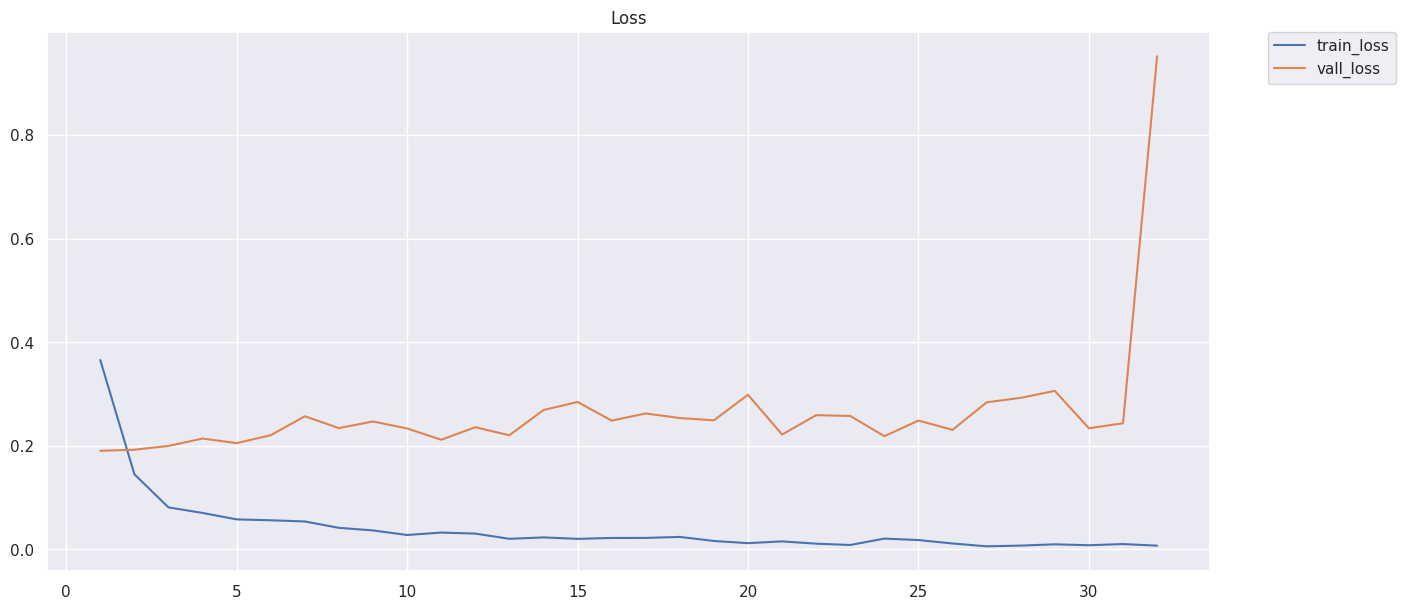

In [41]:
plt.figure(figsize=(15, 7))

plt.plot(np.arange(1, len(train_losses) + 1), train_losses, label="train_loss")
plt.plot(np.arange(1, len(valid_losses) + 1), valid_losses, label="vall_loss")
plt.title("Loss")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

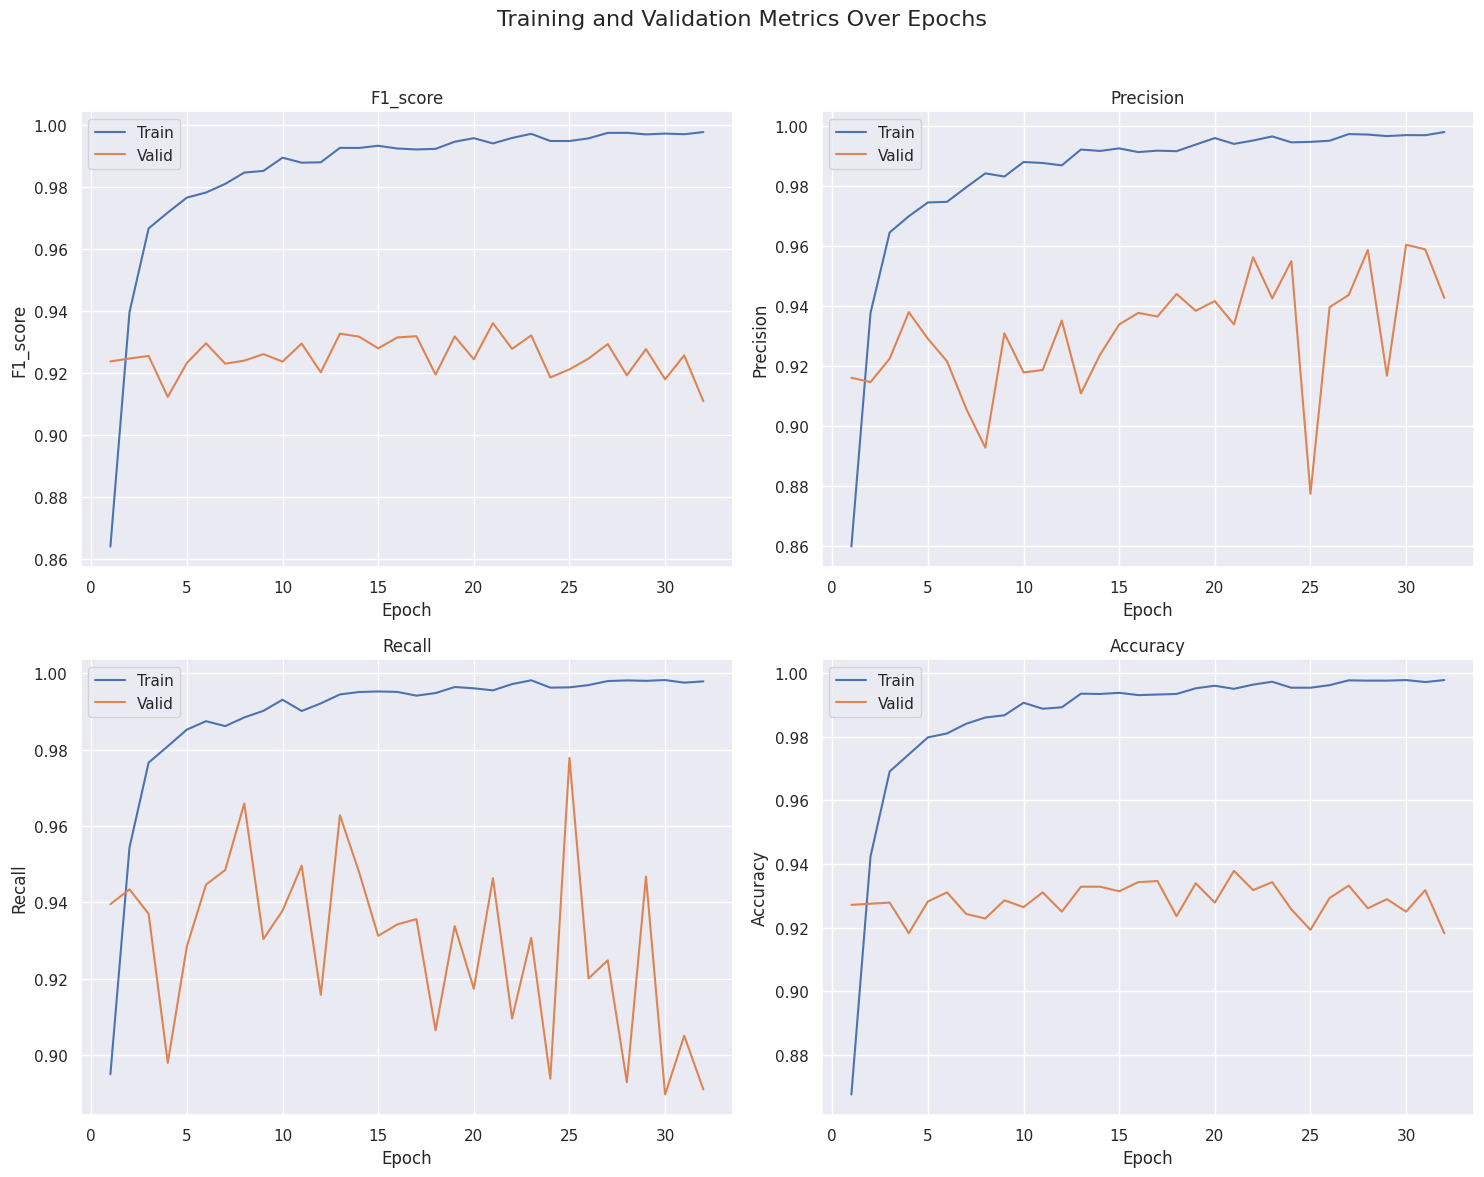

In [42]:
metrics = ['f1_score', 'precision', 'recall', 'accuracy']
epochs = range(1, len(metric_res_valid['f1_score']) + 1)
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Training and Validation Metrics Over Epochs', fontsize=16)
for ax, metric in zip(axes.flatten(), metrics):
    ax.plot(epochs, metric_res_train[metric], label='Train')
    ax.plot(epochs, metric_res_valid[metric], label='Valid')
    ax.set_title(metric.capitalize())
    ax.set_xlabel('Epoch')
    ax.set_ylabel(metric.capitalize())
    ax.legend()
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [43]:
print(f'best_metrics: {best_metrics}')
print(f'best_loss: {min_loss}')
model = trainer.model
model.load_state_dict(best_model_wts)

best_metrics: {'f1_score': 0.9237932138458608, 'precision': 0.9160165865880153, 'recall': 0.9395471036899609, 'accuracy': 0.9271428571428572}
best_loss: 0.19024921367211


<All keys matched successfully>

# Predict test

In [44]:
test_x = data_text[data_text['tag'] == 'test']['Text_lemmatize'].to_list()
test_dataset = TextData(vectorizer_Tfidf, vectorizer_CountVect, tokenizer, 94262, data=test_x)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size, num_workers=8, pin_memory=True)

In [45]:
data_text[data_text['tag'] == 'test']

,idx,Text,tag,Text_clear_stop_words,Text_lemmatize
0,13999,замечательная история об открытии счета в банк...,test,замечательная история открытии счета банке ава...,замечательный история открытие счёт банк аванг...
1,14000,г я досрочно внес сумму указанную операт...,test,г досрочно внес сумму указанную оператором зак...,г досрочно внести сумма указанный оператор зак...
2,14001,была задолженность по кредитной карте банк под...,test,задолженность кредитной карте банк подал суд п...,задолженность кредитный карта банк подать суд ...
3,14002,срочно понадобилась определенная денежная сумм...,test,срочно понадобилась определенная денежная сумм...,срочно понадобиться определённый денежный сумм...
4,14003,здравствуйте в местном отделении бинбанка г ку...,test,здравствуйте местном отделении бинбанка г курч...,здравствуйте местный отделение бинбанка г курч...
...,...,...,...,...,...
5995,19994,уважаемые представители русфинанс банка прошу ...,test,уважаемые представители русфинанс банка прошу ...,уважаемый представитель русфинанс банк просить...
5996,19995,июня сняли с дебетовой карты банка t...,test,июня сняли дебетовой карты банка twd тысяч руб...,июнь снять дебетовый карта банк twd тысяча руб...
5997,19996,в апреле решил я купить шуруповерт посмотрел ц...,test,апреле решил купить шуруповерт посмотрел цены ...,апрель решить купить шуруповерт посмотреть цен...
5998,19997,недавно взял потребкредит в этом банке все чес...,test,недавно взял потребкредит банке честно месяца ...,недавно взять потребкредить банк честно месяц ...


In [46]:
submit = pd.read_csv('/kaggle/input/determining-the-sentiment-of-bank-reviews-dataset/sample_submission.csv', sep='\t')
submit

,idx,Score
0,13999,Positive
1,14000,Positive
2,14001,Positive
3,14002,Positive
4,14003,Positive
...,...,...
5995,19994,Positive
5996,19995,Positive
5997,19996,Positive
5998,19997,Positive


In [47]:
encode_class, decode_class 

({0: 'Positive', 1: 'Negative'}, {'Positive': 0, 'Negative': 1})

In [48]:
res = []
for batch_index, batch in enumerate(tqdm_notebook(test_loader)):
    x_tokenizer, x_Tfidf = batch['tokenizer'].to(device), batch['Tfidf'].to(device)
    x_CountVect = batch['CountVect'].to(device)
    with torch.no_grad():
        output = model(x_tokenizer, x_Tfidf, x_CountVect)
    output_argmax = torch.argmax(output, axis=1)
    res.extend([int(i) for i in output_argmax])
len(res)

  0%|          | 0/375 [00:00<?, ?it/s]

6000

In [49]:
submit['Score'] = res
submit['Score'] = submit['Score'].apply(lambda x: encode_class[x])

In [50]:
submit

,idx,Score
0,13999,Negative
1,14000,Negative
2,14001,Negative
3,14002,Positive
4,14003,Negative
...,...,...
5995,19994,Positive
5996,19995,Positive
5997,19996,Negative
5998,19997,Positive


In [51]:
submit['Score'].value_counts()

Score
Positive    3163
Negative    2837
Name: count, dtype: int64

In [52]:
submit.to_csv('submit_my_NLP_model.csv', sep='\t', index=False)